# Fama-french portfolios
#### Author: Prof. Gustavo Soares

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import bql
bq = bql.Service()

#### Data

Grab the IBOV index and the CDI rate time series like this:

In [2]:
start_date = '2007-12-31'
end_date = pd.to_datetime('today')
bbg_tickers = ['IBOV Index', 'BZACCETP Index']
fields = {'price' : bq.data.px_last(fill='PREV', start=start_date, end=end_date)}
req = bql.Request(bbg_tickers, fields)
res = bq.execute(req)
df = bql.combined_df(res).drop('CURRENCY', 1).pivot_table(index='DATE', columns= 'ID')
df.columns = ['CDI', 'Ibov']
df.to_csv('IBOV_time_series.csv') # This is if you want to save it in a .csv file
df.head()

,CDI,Ibov
DATE,,
2007-12-31,18.10445,63886.1
2008-01-01,18.10445,63886.1
2008-01-02,18.11202,62815.1
2008-01-03,18.11959,62892.0
2008-01-04,18.12715,61036.6


Grab IBOV's members at every month end:

In [3]:
bql_item = bq.data.id()
month_ends = [df.index[i-1] for i in range(1,df.shape[0]) if df.index[i-1].month != df.index[i].month]
ibov_composition = pd.DataFrame()
for eom in month_ends:
    bql_universe = bq.univ.members('IBOV Index', dates=eom)
    bql_request = bql.Request(bql_universe, bql_item)
    bql_response = bq.execute(bql_request)
    ddf = bql.combined_df(bql_response).set_index(['ID()', 'DATE']).drop('ORIG_IDS', 1)
    ibov_composition = ibov_composition.append(ddf)

Grab Total Return series for every member:

In [4]:
all_tickers = ibov_composition.index.get_level_values('ID()').unique()
bql_request = f"get(TOTAL_RETURN_INDEX(DATES=RANGE({start_date}, {end_date.date()}))) for(["
for x in all_tickers:
    bql_request += f"'{x}',"    
bql_request = bql_request[:-1] + "])"
bql_response = bq.execute(bql_request)
tr_df = bql.combined_df(bql_response)

In [5]:
tr_df.to_csv('tr_df.csv')
ibov_composition.to_csv('ibov_composition.csv')

#### Momentum signals

Let's now calculate a momentum signal for every stock at every month end. We will use a 12M-1M momentum signal:

In [6]:
k = 12 # months
mom_signals = pd.Series(index=ibov_composition.index)
signal_start_date = mom_signals.index.get_level_values(1).unique()[1 + k]
for stock, d in mom_signals.index:    
    if stock in tr_df.index and d>=signal_start_date:
        p1 = tr_df.loc[stock].set_index('DATE').shift(21).loc[:d].iloc[-1,0]
        p0 = tr_df.loc[stock].set_index('DATE').shift(21).loc[:d].iloc[-k*21,0]
        mom_signals.loc[stock, d] = p1/p0 -1
mom_signals.index = mom_signals.index.swaplevel(0,1)

#### Momentum portfolios

Let's now pick the top (20%) and bottom (20%) stocks according to our momentum signal:

In [7]:
mom_portfolios = {}
for eom in mom_signals.dropna().index.get_level_values('DATE').unique():
    stocks_on_date = mom_signals.loc[eom].dropna().rank()
    n = stocks_on_date.shape[0]
    date_port = {
        'top' : stocks_on_date[stocks_on_date>n-n/5].index,
        'bottom' : stocks_on_date[stocks_on_date<n/5].index
    }
    mom_portfolios[eom] = date_port

#### Momentum portfolios returns

In [8]:
def weights_on_date(d, port_name):
    w = ibov_composition.loc[[(x,d) for x in mom_portfolios[d][port_name]]]['Weights'].fillna(0)
    w = w/w.sum()
    w.index = w.index.droplevel(level='DATE')
    return w

def quant_on_date(d, port_name, notional):
    w = weights_on_date(d, port_name)
    ref_date = max([x for x in tr_df['DATE'].unique() if x < d])
    prices = tr_df[tr_df['DATE']==ref_date].loc[w.index].drop('DATE', 1).iloc[:,0]
    return notional * w / prices
    
    
calendar = [d for d in tr_df.DATE.unique() if d>=signal_start_date]
backtests = pd.DataFrame(index=calendar, columns=['top', 'bottom'])
backtests.iloc[0] = 100
quant = {
    'q_top' : quant_on_date(signal_start_date, 'top', backtests.iloc[0,0]),
    'q_bottom' : quant_on_date(signal_start_date, 'bottom', backtests.iloc[0,1]),
}

for tdy, yst in zip(calendar[1:], calendar[:-1]):
    # calculate pnl of the top stocks
    p1top = tr_df[tr_df['DATE']==tdy].loc[quant['q_top'].index].drop('DATE', 1).iloc[:,0]
    p0top = tr_df[tr_df['DATE']==yst].loc[quant['q_top'].index].drop('DATE', 1).iloc[:,0]
    toppnl = (quant['q_top'] * (p1top - p0top)).sum()
    backtests.loc[tdy, 'top'] = backtests.loc[yst, 'top'] + toppnl
    # calculate pnl of the bottom stocks
    p1bot = tr_df[tr_df['DATE']==tdy].loc[quant['q_bottom'].index].drop('DATE', 1).iloc[:,0]
    p0bot = tr_df[tr_df['DATE']==yst].loc[quant['q_bottom'].index].drop('DATE', 1).iloc[:,0]
    botpnl = (quant['q_bottom'] * (p1bot - p0bot)).sum()
    backtests.loc[tdy, 'bottom'] = backtests.loc[yst, 'bottom'] + botpnl
    
    if yst in mom_portfolios.keys(): # rebalance the portfolio
        quant = {
        'q_top' : quant_on_date(yst, 'top', backtests.loc[tdy, 'top']),
        'q_bottom' : quant_on_date(yst, 'bottom', backtests.loc[tdy, 'bottom']),
        }
backtests.head()

,top,bottom
2009-01-31,100,100
2009-02-01,100,100
2009-02-02,98.9162,99.1576
2009-02-03,99.5875,101.255
2009-02-04,98.8689,99.9604


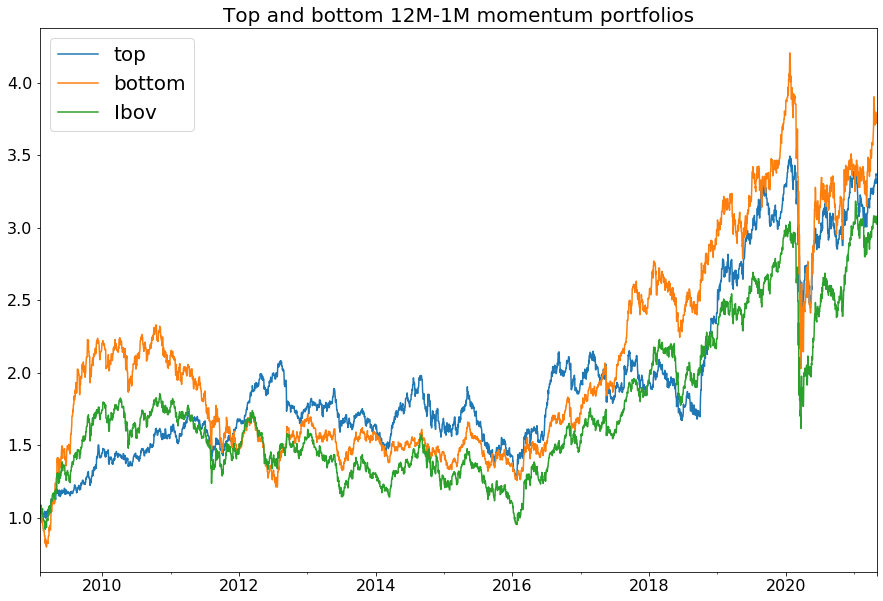

In [9]:
df2 = pd.concat([backtests, df], axis=1, sort=True).dropna().drop('CDI', 1).astype(float)
df2 = np.exp(np.log(df2).diff(1).fillna(0).cumsum())
df2.plot(figsize=(15,10), fontsize=16)
plt.title('Top and bottom 12M-1M momentum portfolios', fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Exercise

Construct a table that presents the one-year-ahead excess returns of the value-weighted portfolios formed
by sorting on momentum. The column labeled t indicates the portfolio formation year. The column labeled t + 1 indicates the portfolio holding year. The columns labeled Q1, ..., Q5 show the excess returns of the five momentum-sorted portfolios. The column labeled Q5-Q1 presents the difference between the return of portfolio Q5 and that of portfolio Q1.

#### Exercise

Calculate the backtest of a long-short portfolio considering that the amount of money obtaining by shorting the bottom stocks is used to buy the top stocks. How would borrow rates affect your results? Assume you have data on borrowing rates, so you have the borrowing rates prevaling for each stock at each point in time. Calculate the backtest considering borrowing rates.

#### Exercise

Calculate the backtest of a long-short portfolio considering that the amount of money obtaining by shorting the bottom stocks is used to buy the top stocks. How would transaction costs affect your results? Assume you have data on transaction costs, so you have the transaction costs prevaling for each stock at each point in time. Calculate the backtest considering transaction costs.